In [1]:
# Change the task_name to either Hyperbole or Metaphor
task_name = "Metaphor"

# Change the dataset name to to the csv file name in use
dataset_name = "new_combined"

# Change the model_name to one of the following names
# BERT large    ----> bert-large-uncased
# ALBERT large  ----> albert-xxlarge-v2
# RoBERTa large ----> roberta-large
model_name = "bert-large-uncased"

seed_val = 42

# Change the numbers in random_list for 3 runs of 10-fold cross-validation run
random_list = [42,101,2020]

# Change random_st variable for the 10-fold cross-validation run
random_st = 42

# Hyperparameters
MAX_LEN=64
batch_size = 16
epochs = 10
learning_rate = 1e-5

In [2]:
!pip install transformers --quiet
from transformers import *

import time
import datetime

import random
import pandas as pd
import numpy as np
import os

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score

import pickle
from tqdm import tqdm, trange
import tensorflow as tf

from operator import itemgetter
from statistics import mean, stdev

import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.3 MB 43.5 MB/s 
     |████████████████████████████████| 163 kB 58.2 MB/s 
     |████████████████████████████████| 7.6 MB 48.8 MB/s 


In [3]:
# Set the seed value all over the place to make this reproducible.
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found!')
print('GPU found at: {}'.format(device_name))

GPU found at: /device:GPU:0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [7]:
df = pd.read_csv(dataset_name+'.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.dropna(axis=0).reset_index(drop=True)

df["Hyperbole"] = df["Hyperbole"].astype("int")
df["Metaphor"] = df["Metaphor"].astype("int")

df.head()

,Sentence,Hyperbole,Metaphor
0,"Insolent boy, I'll slash you to ribbons!",1,1
1,The level of discombobulation in the realm of ...,1,1
2,His eyes were very dark.,0,0
3,It's been a long time since I found someone ni...,0,0
4,"Oh, you are soaked to the bone, monsieur.",1,1


In [8]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['Hyperbole', 'Metaphor']


In [9]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,Sentence,Hyperbole,Metaphor,one_hot_labels
0,"Insolent boy, I'll slash you to ribbons!",1,1,"[1, 1]"
1,The level of discombobulation in the realm of ...,1,1,"[1, 1]"
2,His eyes were very dark.,0,0,"[0, 0]"
3,It's been a long time since I found someone ni...,0,0,"[0, 0]"
4,"Oh, you are soaked to the bone, monsieur.",1,1,"[1, 1]"


In [10]:
conditions = [
    (df["Hyperbole"]==0) & (df["Metaphor"]==0),
    (df["Hyperbole"]==0) & (df["Metaphor"]==1),
    (df["Hyperbole"]==1) & (df["Metaphor"]==0),
    (df["Hyperbole"]==1) & (df["Metaphor"]==1)
]
choices = [0,1,2,3]

df["new"] = np.select(conditions, choices)
df.head()

,Sentence,Hyperbole,Metaphor,one_hot_labels,new
0,"Insolent boy, I'll slash you to ribbons!",1,1,"[1, 1]",3
1,The level of discombobulation in the realm of ...,1,1,"[1, 1]",3
2,His eyes were very dark.,0,0,"[0, 0]",0
3,It's been a long time since I found someone ni...,0,0,"[0, 0]",0
4,"Oh, you are soaked to the bone, monsieur.",1,1,"[1, 1]",3


In [11]:
print(df["Metaphor"].value_counts())
print(df["Hyperbole"].value_counts())
print(df.new.value_counts())

y= df["new"].values

0    796
1    622
Name: Metaphor, dtype: int64
1    709
0    709
Name: Hyperbole, dtype: int64
0    602
3    515
2    194
1    107
Name: new, dtype: int64


In [12]:
labels = list(df.one_hot_labels.values)
comments = list(df.Sentence.values)

In [13]:
df.rename(columns = {"Sentence":"sentence", task_name:"target"}, inplace=True)
df.head()

,sentence,Hyperbole,target,one_hot_labels,new
0,"Insolent boy, I'll slash you to ribbons!",1,1,"[1, 1]",3
1,The level of discombobulation in the realm of ...,1,1,"[1, 1]",3
2,His eyes were very dark.,0,0,"[0, 0]",0
3,It's been a long time since I found someone ni...,0,0,"[0, 0]",0
4,"Oh, you are soaked to the bone, monsieur.",1,1,"[1, 1]",3


In [14]:
labels = df.target.values

In [15]:
model_name = "bert-large-uncased" 

model = AutoModelForSequenceClassification.from_pretrained(model_name) 

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytorch_model.bin
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidd

In [16]:
input_ids = []
attention_masks = []

for i in range(len(df)):
    tokenizer.padding_side = 'right'
    encoded_sent = tokenizer.encode_plus(
                        df['sentence'][i],  
                        add_special_tokens = True, 
                        max_length = MAX_LEN,
                        pad_to_max_length = True
                        )

    input_ids.append(encoded_sent['input_ids'])
    attention_masks.append(encoded_sent['attention_mask'])

print('original: ' , df['sentence'][100])
print('Token IDs:', input_ids[-1])
print('MASK IDs:', attention_masks[-1])
print(tokenizer.cls_token_id, tokenizer.sep_token_id)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


original:  A day was twenty-four hours long but seemed longer.
Token IDs: [101, 100, 2038, 1037, 2200, 8052, 3716, 2055, 1996, 8605, 5130, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MASK IDs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
101 102


In [18]:
print("Total number of samples: ", len(input_ids))

Total number of samples:  1418


In [20]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print(pred_flat, labels_flat)
    return f1_score(labels_flat, pred_flat)

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
final_list = []

for ran in random_list:
    random_state = ran
    kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
    f1_list=[]
    for i,(train_index, validation_index) in enumerate(kf.split(input_ids,y)):
      z=i
      # if i==2:
      #   break
      print()
      print("---------------------------------FOLD NO: ", i)
      # print(train_index, validation_index)
      train_inputs = list(itemgetter(*train_index)(input_ids))
      train_labels = list(itemgetter(*train_index)(labels))
      train_masks = list(itemgetter(*train_index)(attention_masks))

      validation_inputs = list(itemgetter(*validation_index)(input_ids))
      validation_labels = list(itemgetter(*validation_index)(labels))
      validation_masks = list(itemgetter(*validation_index)(attention_masks))

      train_inputs = torch.tensor(train_inputs)
      validation_inputs = torch.tensor(validation_inputs)

      train_labels = torch.tensor(train_labels)
      validation_labels = torch.tensor(validation_labels)

      train_masks = torch.tensor(train_masks)
      validation_masks = torch.tensor(validation_masks)

      
      train_data = TensorDataset(train_inputs, train_masks, train_labels)
      train_sampler = RandomSampler(train_data)
      train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

      
      validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
      validation_sampler = SequentialSampler(validation_data)
      validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

      model = AutoModelForSequenceClassification.from_pretrained(model_name) 
      tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

      model.cuda();
      optimizer = AdamW(model.parameters(),
                        lr = learning_rate, 
                        eps = 1e-8 
                      )


      
      print('len(train_dataloader)', len(train_dataloader))
      total_steps = len(train_dataloader) * epochs
      print('total_steps', total_steps)
      warmup_steps = int(0.06 * total_steps)
      print('warmup_steps', warmup_steps)
     
      scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                  num_warmup_steps = warmup_steps, # Default value in run_glue.py
                                                  num_training_steps = total_steps)

     
      loss_values = []

      
      for epoch_i in range(0, epochs):

          # ========================================
          #               Training
          # ========================================

          

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
          print('Training...')

          
          t0 = time.time()

          
          total_loss = 0

          
          model.train()

          
          for step, batch in enumerate(train_dataloader):

            
              if step % 40 == 0 and not step == 0:
                  
                  elapsed = format_time(time.time() - t0)

                 
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}    LR . {:.2E}'.format(step, len(train_dataloader), elapsed, scheduler.get_lr()[0]))

           
              b_input_ids = batch[0].to(device)
              b_input_mask = batch[1].to(device)
              b_labels = batch[2].to(device)
               
              model.zero_grad()        

              outputs = model(b_input_ids, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)

              
              loss = outputs[0]

              total_loss += loss.item()

              loss.backward()

              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

              optimizer.step()

              scheduler.step()

          avg_train_loss = total_loss / len(train_dataloader)            

          loss_values.append(avg_train_loss)

          print("")
          print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

          # ========================================
          #               Validation
          # ========================================
         

          print("")
          print("Running Validation...")

          t0 = time.time()

          model.eval()
          eval_loss, eval_accuracy = 0, 0
          nb_eval_steps, nb_eval_examples = 0, 0

          for batch in validation_dataloader:

              batch = tuple(t.to(device) for t in batch)

              b_input_ids, b_input_mask, b_labels = batch

              with torch.no_grad():        

                  outputs = model(b_input_ids, 
                                  attention_mask=b_input_mask)

              logits = outputs[0]

              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              tmp_eval_accuracy = flat_accuracy(logits, label_ids)
              print(tmp_eval_accuracy)

              eval_accuracy += tmp_eval_accuracy

              nb_eval_steps += 1

          print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
          print("  Validation took: {:}".format(format_time(time.time() - t0)))

      print("")
      print("Training complete!")

      print('Predicting labels for {:,} dev sentences...'.format(len(validation_inputs)))

      model.eval()

      predictions , true_labels = [], []

      for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

      print('    DONE.')
      pred_list=[]
      true_list=[]
      for i in range(len(true_labels)):
        pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
        pred_list.extend(list(pred_labels_i))
        true_list.extend(list(true_labels[i]))

      from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, fbeta_score

      print("---------------------------------Confusion Matrix------------------------------------")
      final_create_confusion_matrix = confusion_matrix(true_list, pred_list)
      final_confusion_matrix_df = pd.DataFrame(final_create_confusion_matrix)
      display(final_confusion_matrix_df)
      # Precision, Recall and F1 score calculation
      final_eval_metrics = classification_report(true_list, pred_list, output_dict=True)

      # computing other f-beta scores
      f_0_5_micro = fbeta_score(true_list, pred_list, beta = 0.5, average = 'micro')
      f_0_5_macro = fbeta_score(true_list, pred_list, beta = 0.5, average = 'macro')
      f_0_5_weighted = fbeta_score(true_list, pred_list, beta = 0.5, average = 'weighted')

      f_1_micro = fbeta_score(true_list, pred_list, beta = 1, average = 'micro')
      f_1_macro = fbeta_score(true_list, pred_list, beta = 1, average = 'macro')
      f_1_weighted = fbeta_score(true_list, pred_list, beta = 1, average = 'weighted')

      f_2_micro = fbeta_score(true_list, pred_list, beta = 2, average = 'micro')
      f_2_macro = fbeta_score(true_list, pred_list, beta = 2, average = 'macro')
      f_2_weighted = fbeta_score(true_list, pred_list, beta = 2, average = 'weighted')

      print("---------------------------------Evaluation Metrics------------------------------------")
      final_eval_metrics_df = pd.DataFrame(final_eval_metrics).transpose()
      final_eval_metrics_df = final_eval_metrics_df.iloc[: , :-1]
      display(final_eval_metrics_df)
      # F-beta scores dataframe
      data = {'F1-score':[f_1_micro, f_1_macro, f_1_weighted],
              'F0.5-score':[f_0_5_micro, f_0_5_macro, f_0_5_weighted],
              'F2-score':[f_2_micro, f_2_macro, f_2_weighted]}
      f_beta_df = pd.DataFrame(data, index =['Micro-Average','Macro-Average','Weighted-Average'])
      display(f_beta_df)
      print("---------------------------------Normalized Matrix------------------------------------")

      f1_list.append(final_eval_metrics)
 
    final_list.extend(f1_list)


---------------------------------FOLD NO:  0


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytor

len(train_dataloader) 80
total_steps 800
warmup_steps 48

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:30    LR . 8.33E-06

  Average training loss: 0.67
  Training epcoh took: 0:00:58

Running Validation...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.0
[0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.5714285714285714
[1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.3333333333333333
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.0
[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.36363636363636365
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.2857142857142857
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.3636363636363636
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.28
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 9.04E-06

  Average training loss: 0.52
  Training epcoh took: 0:00:55

Running Validation...
[1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.7272727272727273
[1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7777777777777778
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.75
[1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7058823529411765
[0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.5
[0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.875
[0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6153846153846153
[0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.9411764705882353
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.72
  Validation took: 0:00:02

======== Epoch 3 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:28    LR . 7.98E-06

  Average training loss: 0.38
  Training epcoh took: 0:00:55

Running Validation...
[0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.6
[1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7777777777777778
[1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.75
[1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.5
[0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.7999999999999999
[0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6153846153846153
[0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.9411764705882353
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.71
  Validation took: 0:00:02

======== Epoch 4 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 6.91E-06

  Average training loss: 0.24
  Training epcoh took: 0:00:55

Running Validation...
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.3333333333333333
[1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7142857142857143
[1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.5714285714285714
[1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5
[0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666665
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5454545454545454
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5
[0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.6153846153846153
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.56
  Validation took: 0:00:02

======== Epoch 5 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.85E-06

  Average training loss: 0.15
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.28571428571428575
[1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.8750000000000001
[1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.5714285714285714
[1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.75
[0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5
[0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6666666666666666
[0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.7142857142857143
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.61
  Validation took: 0:00:02

======== Epoch 6 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 4.79E-06

  Average training loss: 0.11
  Training epcoh took: 0:00:54

Running Validation...
[0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.6
[1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.8421052631578948
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.823529411764706
[1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.823529411764706
[1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.7692307692307692
[0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.76
  Validation took: 0:00:02

======== Epoch 7 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 3.72E-06

  Average training loss: 0.07
  Training epcoh took: 0:00:54

Running Validation...
[0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.4444444444444445
[1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.8421052631578948
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.823529411764706
[1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.5454545454545454
[0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.75
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.7272727272727272
[0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.72
  Validation took: 0:00:02

======== Epoch 8 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 2.66E-06

  Average training loss: 0.06
  Training epcoh took: 0:00:54

Running Validation...
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.823529411764706
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.823529411764706
[1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666665
[0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5714285714285715
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.7272727272727272
[0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.71
  Validation took: 0:00:02

======== Epoch 9 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 1.60E-06

  Average training loss: 0.04
  Training epcoh took: 0:00:54

Running Validation...
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.823529411764706
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.823529411764706
[1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6
[0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.75
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.7272727272727272
[0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.73
  Validation took: 0:00:02

======== Epoch 10 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.32E-07

  Average training loss: 0.03
  Training epcoh took: 0:00:54

Running Validation...
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.8888888888888888
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.823529411764706
[1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.7142857142857143
[0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6
[0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.75
[0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.7272727272727272
[0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.73
  Validation took: 0:00:02

Training complete!
Predicting labels for 142 dev sentences...
    DONE.
-----

,0,1
0,67,13
1,16,46


---------------------------------Evaluation Metrics------------------------------------


,precision,recall,f1-score
0,0.807229,0.837500,0.822086
1,0.779661,0.741935,0.760331
accuracy,0.795775,0.795775,0.795775
macro avg,0.793445,0.789718,0.791208
weighted avg,0.795192,0.795775,0.795122


,F1-score,F0.5-score,F2-score
Micro-Average,0.795775,0.795775,0.795775
Macro-Average,0.791208,0.792459,0.790226
Weighted-Average,0.795122,0.795077,0.795428


---------------------------------Normalized Matrix------------------------------------

---------------------------------FOLD NO:  1


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytor

len(train_dataloader) 80
total_steps 800
warmup_steps 48

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 8.33E-06

  Average training loss: 0.70
  Training epcoh took: 0:00:55

Running Validation...
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.18181818181818182
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.2857142857142857
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.0
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.33333333333333337
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.0
[0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.6666666666666666
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.1818181818181818
[0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.0
  Accuracy: 0.23
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 9.04E-06

  Average training loss: 0.61
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.6666666666666666
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.25
[1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.6666666666666666
[0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.4285714285714285
[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.5714285714285715
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.6
[0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.3333333333333333
[0 0 0 0 0 0 1 0 0 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.8571428571428571
  Accuracy: 0.57
  Validation took: 0:00:02

======== Epoch 3 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 7.98E-06

  Average training loss: 0.48
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.6
[1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.875
[1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.588235294117647
[0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.888888888888889
[0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.6666666666666665
[0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.6
[1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.6250000000000001
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 4 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 6.91E-06

  Average training loss: 0.34
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.7499999999999999
[0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.4444444444444444
[1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.9333333333333333
[1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.625
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.7499999999999999
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.6
[1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.42857142857142855
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.69
  Validation took: 0:00:02

======== Epoch 5 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.85E-06

  Average training loss: 0.24
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.6666666666666666
[1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.8571428571428571
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.7499999999999999
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.7272727272727272
[1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.6250000000000001
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 6 / 10 ========
Tra

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 4.79E-06

  Average training loss: 0.16
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.7272727272727272
[1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.823529411764706
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.888888888888889
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.7142857142857143
[1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.631578947368421
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.76
  Validation took: 0:00:02

======== Epoch 7 / 10 ========
Traini

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 3.72E-06

  Average training loss: 0.12
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.6666666666666666
[1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.823529411764706
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.7499999999999999
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.7692307692307692
[1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.6666666666666666
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.75
  Validation took: 0:00:02

======== Epoch 8 / 10 ========
Trai

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 2.66E-06

  Average training loss: 0.09
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.5
[1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.7999999999999999
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.7499999999999999
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.6666666666666666
[1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.6666666666666666
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.72
  Validation took: 0:00:02

======== Epoch 9 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 1.60E-06

  Average training loss: 0.07
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.8
[1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.75
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.888888888888889
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.7692307692307692
[1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.631578947368421
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.77
  Validation took: 0:00:02

======== Epoch 10 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.32E-07

  Average training loss: 0.06
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
0.888888888888889
[0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0] [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0]
0.8
[1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0]
0.75
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1] [0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1]
0.5333333333333333
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0] [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0]
0.7499999999999999
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
0.7499999999999999
[0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0] [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0]
0.7692307692307692
[1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0] [1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1]
0.631578947368421
[0 0 0 0 0 0 1 1 1 0 0 0 1 1] [0 0 0 0 0 0 1 1 0 0 0 0 1 1]
0.888888888888889
  Accuracy: 0.75
  Validation took: 0:00:02

Training complete!
Predicting labels for 142 dev sentences...
  

,0,1
0,69,10
1,20,43


---------------------------------Evaluation Metrics------------------------------------


,precision,recall,f1-score
0,0.775281,0.873418,0.821429
1,0.811321,0.682540,0.741379
accuracy,0.788732,0.788732,0.788732
macro avg,0.793301,0.777979,0.781404
weighted avg,0.791270,0.788732,0.785914


,F1-score,F0.5-score,F2-score
Micro-Average,0.788732,0.788732,0.788732
Macro-Average,0.781404,0.787461,0.778385
Weighted-Average,0.785914,0.788097,0.786663


---------------------------------Normalized Matrix------------------------------------

---------------------------------FOLD NO:  0


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytor

len(train_dataloader) 80
total_steps 800
warmup_steps 48

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 8.33E-06

  Average training loss: 0.69
  Training epcoh took: 0:00:55

Running Validation...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0]
0.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 1 0 1 1 0 0 0 0 1]
0.0
  Accuracy: 0.04
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 9.04E-06

  Average training loss: 0.61
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1] [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1]
0.42857142857142855
[0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0] [0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0]
0.5454545454545454
[1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0] [0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0]
0.8750000000000001
[0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1] [0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1]
0.8888888888888888
[1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0] [0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1]
0.5
[1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0] [1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0]
0.923076923076923
[0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0] [0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0]
0.6153846153846153
[0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0] [0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1]
0.4444444444444444
[0 0 0 1 0 0 0 1 1 0 0 1 0 1] [0 0 0 1 0 1 0 1 1 0 0 0 0 1]
0.8000000000000002
  Accuracy: 0.67
  Validation took: 0:00:02

======== Epoch 3 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 7.98E-06

  Average training loss: 0.44
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1] [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1]
0.46153846153846156
[1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0] [0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0]
0.5
[1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1] [0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0]
0.8235294117647058
[0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1] [0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1]
0.8888888888888888
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0] [0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1]
0.5454545454545454
[1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0] [1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0]
0.8571428571428571
[0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0] [0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0]
0.8571428571428571
[0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1]
0.8
[0 0 0 0 0 0 0 1 1 0 0 1 0 1] [0 0 0 1 0 1 0 1 1 0 0 0 0 1]
0.6666666666666665
  Accuracy: 0.71
  Validation took: 0:00:02

======== Epoch 4 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 6.91E-06

  Average training loss: 0.30
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1] [0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1]
0.5
[0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0] [0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0]
0.6
[1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0] [0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0]
0.7999999999999999
[0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1] [0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1]
0.823529411764706
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0] [0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1]
0.6666666666666666
[1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0] [1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0]
0.8333333333333333
[0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0] [0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0]
0.8571428571428571
[0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1]
0.8
[0 0 0 0 0 0 0 1 1 0 1 1 0 1] [0 0 0 1 0 1 0 1 1 0 0 0 0 1]
0.6
  Accuracy: 0.72
  Validation took: 0:00:02

======== Epoch 5 / 10 ========
Training...


KeyboardInterrupt: ignored

In [24]:
p = []
r = []
f1 = []
for f in final_list:
    p.append(f["1"]["precision"])
    r.append(f["1"]["recall"])
    f1.append(f["1"]["f1-score"])

In [27]:
print(task_name + " results")
print()
print("Precision",mean(p))
print("Recall",mean(r))
print("F1 score",mean(f1))
print("Std Dev",stdev(f1))

Metaphor results

Precision 0.7954908858330669
Recall 0.7122375832053252
F1 score 0.7508549444286121
Std Dev 0.013400570233373018


Run the following cell to obtain prediction files and models for 10-fold cross validation (single run)

In [28]:
kf = StratifiedKFold(n_splits=10, random_state=random_st, shuffle=True)
f1_list=[]
for i,(train_index, validation_index) in enumerate(kf.split(input_ids,y)):
  z=i
  if i==1:
    break
  print()
  print("---------------------------------FOLD NO: ", i)

  train_inputs = list(itemgetter(*train_index)(input_ids))
  train_labels = list(itemgetter(*train_index)(labels))
  train_masks = list(itemgetter(*train_index)(attention_masks))

  validation_inputs = list(itemgetter(*validation_index)(input_ids))
  validation_labels = list(itemgetter(*validation_index)(labels))
  validation_masks = list(itemgetter(*validation_index)(attention_masks))


  train_inputs = torch.tensor(train_inputs)
  validation_inputs = torch.tensor(validation_inputs)

  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(validation_labels)
  
  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)


  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = AutoModelForSequenceClassification.from_pretrained(model_name) 
  tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

  model.cuda();
  optimizer = AdamW(model.parameters(),
                    lr = learning_rate, 
                    eps = 1e-8 
                  )

  
  print('len(train_dataloader)', len(train_dataloader))
  total_steps = len(train_dataloader) * epochs
  print('total_steps', total_steps)
  warmup_steps = int(0.06 * total_steps)
  print('warmup_steps', warmup_steps)

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = warmup_steps,
                                              num_training_steps = total_steps)
  
  
  loss_values = []

  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()

      total_loss = 0

      model.train()

      for step, batch in enumerate(train_dataloader):

          if step % 40 == 0 and not step == 0:
             
              elapsed = format_time(time.time() - t0)
              
             
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}    LR . {:.2E}'.format(step, len(train_dataloader), elapsed, scheduler.get_lr()[0]))

          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()        

          outputs = model(b_input_ids, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          loss = outputs[0]
          total_loss += loss.item()

          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()

          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================
      

      print("")
      print("Running Validation...")

      t0 = time.time()
      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch

          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              attention_mask=b_input_mask)
          
          logits = outputs[0]

          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          print(tmp_eval_accuracy)
          
          eval_accuracy += tmp_eval_accuracy

          nb_eval_steps += 1

      print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")

  print('Predicting labels for {:,} dev sentences...'.format(len(validation_inputs)))

  model.eval()
  predictions , true_labels = [], []

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)

  print('    DONE.')
  pred_list=[]
  true_list=[]
  for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    pred_list.extend(list(pred_labels_i))
    true_list.extend(list(true_labels[i]))

  from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, fbeta_score
  # Consolidated evaluation metrics
  print("---------------------------------Confusion Matrix------------------------------------")
  final_create_confusion_matrix = confusion_matrix(true_list, pred_list)
  final_confusion_matrix_df = pd.DataFrame(final_create_confusion_matrix)
  display(final_confusion_matrix_df)
  # Precision, Recall and F1 score calculation
  final_eval_metrics = classification_report(true_list, pred_list, output_dict=True)

  # computing other f-beta scores
  f_0_5_micro = fbeta_score(true_list, pred_list, beta = 0.5, average = 'micro')
  f_0_5_macro = fbeta_score(true_list, pred_list, beta = 0.5, average = 'macro')
  f_0_5_weighted = fbeta_score(true_list, pred_list, beta = 0.5, average = 'weighted')

  f_1_micro = fbeta_score(true_list, pred_list, beta = 1, average = 'micro')
  f_1_macro = fbeta_score(true_list, pred_list, beta = 1, average = 'macro')
  f_1_weighted = fbeta_score(true_list, pred_list, beta = 1, average = 'weighted')

  f_2_micro = fbeta_score(true_list, pred_list, beta = 2, average = 'micro')
  f_2_macro = fbeta_score(true_list, pred_list, beta = 2, average = 'macro')
  f_2_weighted = fbeta_score(true_list, pred_list, beta = 2, average = 'weighted')

  print("---------------------------------Evaluation Metrics------------------------------------")
  final_eval_metrics_df = pd.DataFrame(final_eval_metrics).transpose()
  final_eval_metrics_df = final_eval_metrics_df.iloc[: , :-1]
  display(final_eval_metrics_df)
  # F-beta scores dataframe
  data = {'F1-score':[f_1_micro, f_1_macro, f_1_weighted],
          'F0.5-score':[f_0_5_micro, f_0_5_macro, f_0_5_weighted],
          'F2-score':[f_2_micro, f_2_macro, f_2_weighted]}
  f_beta_df = pd.DataFrame(data, index =['Micro-Average','Macro-Average','Weighted-Average'])
  display(f_beta_df)
  print("---------------------------------Normalized Matrix------------------------------------")

  f1_list.append(final_eval_metrics)

  path_name = dataset_name + "/stl/" + task_name +"/" + str(random_st)
  file_path = path_name + "/predictions"+str(z)+ ".csv"
  model_path = path_name + "/model" + str(z)

  if not os.path.exists(path_name):
    os.makedirs(path_name)
  
  val_sent = list(itemgetter(*validation_index)(df.sentence.values))

  pred_df = pd.DataFrame(list(zip(val_sent, true_list, pred_list)), columns=["sentence","true_label","pred_label"])
  pred_df.to_csv(file_path)
  model.save_pretrained(model_path) 

    


---------------------------------FOLD NO:  0


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/3835a195d41f7ddc47d5ecab84b64f71d6f144e9/pytor

len(train_dataloader) 80
total_steps 800
warmup_steps 48

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:28    LR . 8.33E-06

  Average training loss: 0.76
  Training epcoh took: 0:00:55

Running Validation...
[1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.6250000000000001
[1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.7777777777777778
[0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5
[1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.5333333333333333
[0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5714285714285715
[0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5
[0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.7777777777777778
[1 1 0 0 0 1 1 0 0 0 0 0 1 0] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.8000000000000002
  Accuracy: 0.62
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 9.04E-06

  Average training loss: 0.57
  Training epcoh took: 0:00:54

Running Validation...
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.4
[1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.6666666666666666
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.7368421052631577
[1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5333333333333333
[1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.5714285714285715
[0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.75
[0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6153846153846153
[0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8421052631578948
[1 1 0 0 0 1 1 0 0 0 0 0 0 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.8000000000000002
  Accuracy: 0.66
  Validation took: 0:00:02

======== Epoch 3 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 7.98E-06

  Average training loss: 0.50
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.4444444444444445
[1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.6666666666666666
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.7368421052631577
[1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5714285714285715
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.6666666666666666
[0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5454545454545454
[0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8888888888888888
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.64
  Validation took: 0:00:02

======== Epoch 4 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 6.91E-06

  Average training loss: 0.36
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5714285714285715
[1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.5333333333333333
[1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.6666666666666667
[0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5
[0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5454545454545454
[0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.6
  Accuracy: 0.61
  Validation took: 0:00:02

======== Epoch 5 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.85E-06

  Average training loss: 0.25
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.5882352941176471
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.75
[1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.6666666666666666
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.7692307692307693
[0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6666666666666666
[0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
1.0
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.70
  Validation took: 0:00:02

======== Epoch 6 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 4.79E-06

  Average training loss: 0.18
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7368421052631577
[1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.9473684210526316
[1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5714285714285715
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.6153846153846154
[0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6153846153846153
[0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.9411764705882353
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.70
  Validation took: 0:00:02

======== Epoch 7 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 3.72E-06

  Average training loss: 0.14
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.5
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7368421052631577
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.8888888888888888
[0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.4615384615384615
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.6666666666666666
[0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5
[0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5454545454545454
[0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.9411764705882353
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.66
  Validation took: 0:00:02

======== Epoch 8 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 2.66E-06

  Average training loss: 0.08
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.28571428571428575
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7368421052631577
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.8888888888888888
[1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.6666666666666666
[1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.8
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.5454545454545454
[0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6666666666666666
[0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.69
  Validation took: 0:00:02

======== Epoch 9 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 1.60E-06

  Average training loss: 0.07
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.28571428571428575
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7368421052631577
[1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.9473684210526316
[1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.6666666666666666
[1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.7272727272727273
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.6666666666666666
[0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.6666666666666666
[0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.70
  Validation took: 0:00:02

======== Epoch 10 / 10 ========

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  Batch    40  of     80.    Elapsed: 0:00:27    LR . 5.32E-07

  Average training loss: 0.06
  Training epcoh took: 0:00:54

Running Validation...
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0] [0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
0.28571428571428575
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0] [1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
0.7368421052631577
[1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1] [1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1]
0.8888888888888888
[1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0] [1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0]
0.5714285714285715
[1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
0.8
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1] [1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1]
0.6666666666666666
[0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0] [1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
0.5454545454545454
[0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0] [0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
0.8750000000000001
[1 1 0 0 0 1 1 0 0 0 0 0 1 1] [1 1 0 0 0 1 1 0 0 1 0 0 0 0]
0.7272727272727272
  Accuracy: 0.68
  Validation took: 0:00:02

Training complete!
Predicting labels for 142 d

,0,1
0,66,14
1,20,42


---------------------------------Evaluation Metrics------------------------------------


,precision,recall,f1-score
0,0.767442,0.825000,0.795181
1,0.750000,0.677419,0.711864
accuracy,0.760563,0.760563,0.760563
macro avg,0.758721,0.751210,0.753523
weighted avg,0.759826,0.760563,0.758803


,F1-score,F0.5-score,F2-score
Micro-Average,0.760563,0.760563,0.760563
Macro-Average,0.753523,0.756284,0.751799
Weighted-Average,0.758803,0.759075,0.759532


---------------------------------Normalized Matrix------------------------------------


AttributeError: ignored

In [32]:
p = []
r = []
f1 = []
for f in final_list:
    p.append(f["1"]["precision"])
    r.append(f["1"]["recall"])
    f1.append(f["1"]["f1-score"])

In [33]:
print(task_name + " results")
print()
print("Precision",mean(p))
print("Recall",mean(r))
print("F1 score",mean(f1))
print("Std Dev",stdev(f1))

Metaphor results

Precision 0.7954908858330669
Recall 0.7122375832053252
F1 score 0.7508549444286121
Std Dev 0.013400570233373018


Inference on example sentences and attention weights


In [34]:
input_text = "He went a thousand miles to be here."


inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
model = AutoModelForSequenceClassification.from_pretrained(path_name + "/model0", output_attentions=True) 
model.cuda()
outputs = model(inputs.to(device))  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

loading configuration file new_combined/stl/Metaphor/42/model0/config.json
Model config BertConfig {
  "_name_or_path": "new_combined/stl/Metaphor/42/model0",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_attentions": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file new_combined/stl/Metaphor/42/model0/pytorch_model.bin
All model checkpoint weights were used when initia

In [35]:
sum = torch.zeros(len(tokens),len(tokens))
for i in range(16):
    if i==0:
        sum=outputs[-1][-1][0][i]
    sum = torch.add(sum,outputs[-1][-1][0][i])
#     outputs[-1][-1][0][0]
sum[0]/torch.sum(sum[0])

tensor([0.0878, 0.1198, 0.0918, 0.0807, 0.0860, 0.0721, 0.0658, 0.0996, 0.1134,
        0.0698, 0.1131], device='cuda:0', grad_fn=<DivBackward0>)

In [36]:
new_tokens=[]
a = torch.mean(outputs[-1][-1][:,:,0,:],1)[0][1:-1]
for t in tokens:
    new_tokens.append(tokenizer.convert_tokens_to_string(t))
inf_df = pd.DataFrame([(a/torch.sum(a)).tolist()], columns=new_tokens[1:-1])
inf_df

,[ U N K ],w e n t,a,t h o u s a n d,m i l e s,t o,b e,h e r e,.
0,0.153238,0.116093,0.100741,0.108808,0.090103,0.080082,0.121178,0.144854,0.084902


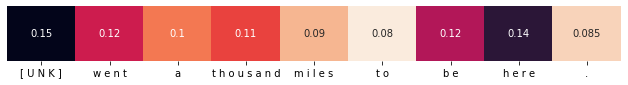

In [37]:
fig, ax = plt.subplots(figsize=(len(tokens), 1))
sns.heatmap(inf_df,cmap=sns.cm.rocket_r, cbar=False, annot=True, yticklabels=False)
plt.show()